In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import visuals as vs
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

df = pd.read_csv('../data/exp3/new/ws_orderinfo_orders_server.csv', header=0)
# filtered_df = df[df['orderdate'].isnull()]
df = df.dropna()
df["orderdate"] = df["orderdate"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))
df["takendate"] = df["takendate"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))
df["shipdate"] = df["shipdate"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))
df["transitDuration"] = (df["shipdate"]-df["takendate"])/ np.timedelta64(1, 's')
df["fulfillDuration"] = (df["shipdate"]-df["orderdate"])/ np.timedelta64(1, 's')

df["amount"] = df["red"]+df["blue"]+df["yellow"]+df["black"]+df["white"]

dic = {}

# Combine with customer info
df_tmp = pd.read_csv('..\data\exp3\ws_orderinfo_demographic.csv', header=0)
df = pd.merge(df, df_tmp, how='inner', left_on="customer", right_on="name")
df = df.drop(columns=['name','orderdate(x)','orderdate','takendate','shipdate', 'id','entryid'])
for key in ["customer","age", "sex", "city", "state", "country",\
                 "income", "credit","education", "occupation"]:
    dic[key] = {}
    ## Add Customer ID (Integer number)
    id = 1
    for _,name in df[[key]].drop_duplicates()[key].iteritems():
        dic[key][name] = id # id starts from 0
        id = id+1
    df[key] = df[key].apply(lambda x: dic[key][x])

    
print "dictionary keys:",dic.keys()
print df.info()

dictionary keys: ['customer', 'city', 'country', 'age', 'sex', 'credit', 'state', 'income', 'education', 'occupation']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 21 columns):
customer           150 non-null int64
red                150 non-null int64
blue               150 non-null int64
green              150 non-null int64
yellow             150 non-null int64
black              150 non-null int64
white              150 non-null int64
pending            150 non-null int64
shipped            150 non-null int64
transitDuration    150 non-null float64
fulfillDuration    150 non-null float64
amount             150 non-null int64
age                150 non-null int64
sex                150 non-null int64
city               150 non-null int64
state              150 non-null int64
country            150 non-null int64
income             150 non-null int64
credit             150 non-null int64
education          150 non-null int64
occupation  

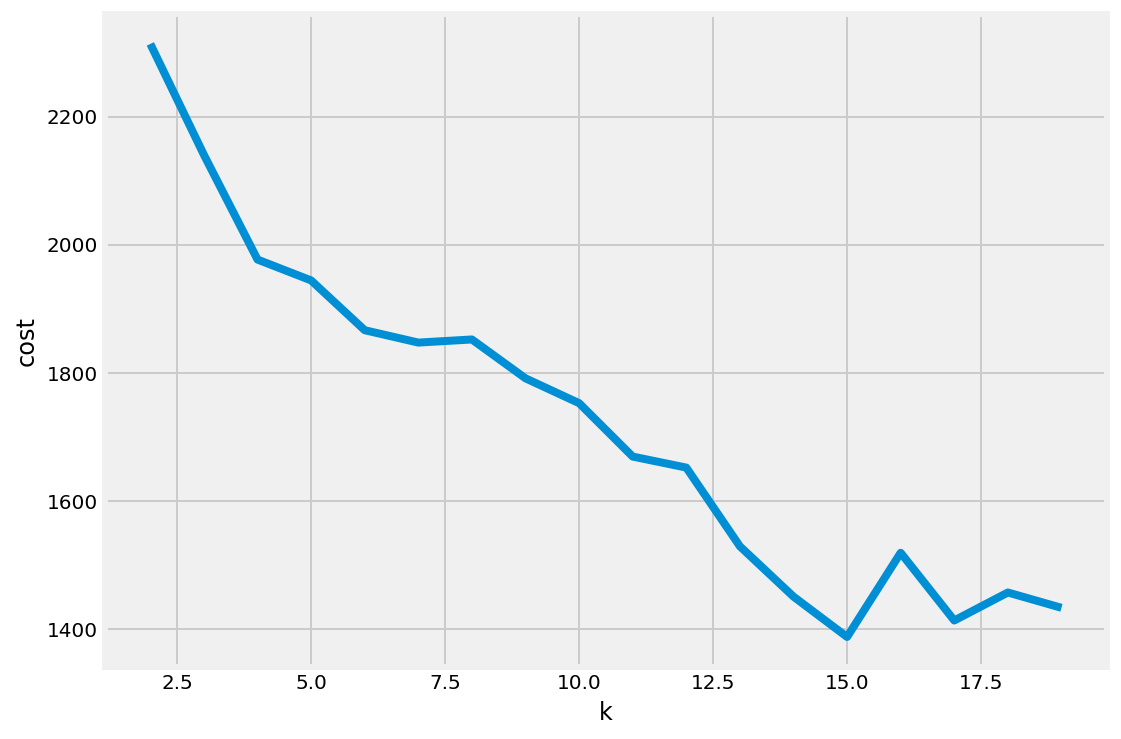

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext, HiveContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

import numpy as np
from numpy import array
from math import sqrt

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

df_spark = sqlCtx.createDataFrame(df)

vecAssembler = VectorAssembler(inputCols=df_spark.columns, outputCol="features")
df_spark = vecAssembler.transform(df_spark)
rdd = df_spark.rdd.map(lambda x: array(x["features"]))

# normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df_spark)
scaledData = scalerModel.transform(df_spark)
scaledRDD = scaledData.rdd.map(lambda x: array(x["scaledFeatures"]))

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(scaledData.sample(False,0.5, seed=42))
    cost[k] = model.computeCost(scaledData) 

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()


In [4]:
k = 11
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
model = kmeans.fit(scaledData)

data = model.transform(scaledData).select("amount","transitDuration", "fulfillDuration", "prediction").toPandas()

summary = model.summary
print summary.clusterSizes

cluster = []
for j in xrange(k):
    cluster.append([i for i in xrange(data["prediction"].size) if data["prediction"][i]==j])

for i in xrange(k):
    print "#########################   cluster: " + str(i+1) + "  #################################" 
    print df.loc[cluster[i]][:10]
    print "##########################################################################################" 
    print 
    print 
    print

[5, 17, 26, 10, 12, 16, 18, 4, 1, 13, 28]
#########################   cluster: 1  #################################
    customer  red  blue  green  yellow  black  white  pending  shipped  \
41        11    0     0      0       4      2     10        0        1   
56        15    0     0      0       5      6      0        0        1   
57        15    0     0      0       8      3      3        0        1   
58        15    0     0      0      10      5     10        0        1   
59        15    0     6      0       9      4      0        0        1   

    transitDuration     ...      amount  age  sex  city  state  country  \
41            140.0     ...          16   11    1    11     10        1   
56            219.0     ...          11   14    1    15      1        1   
57            266.0     ...          14   14    1    15      1        1   
58            231.0     ...          25   14    1    15      1        1   
59            235.0     ...          19   14    1    15      1  

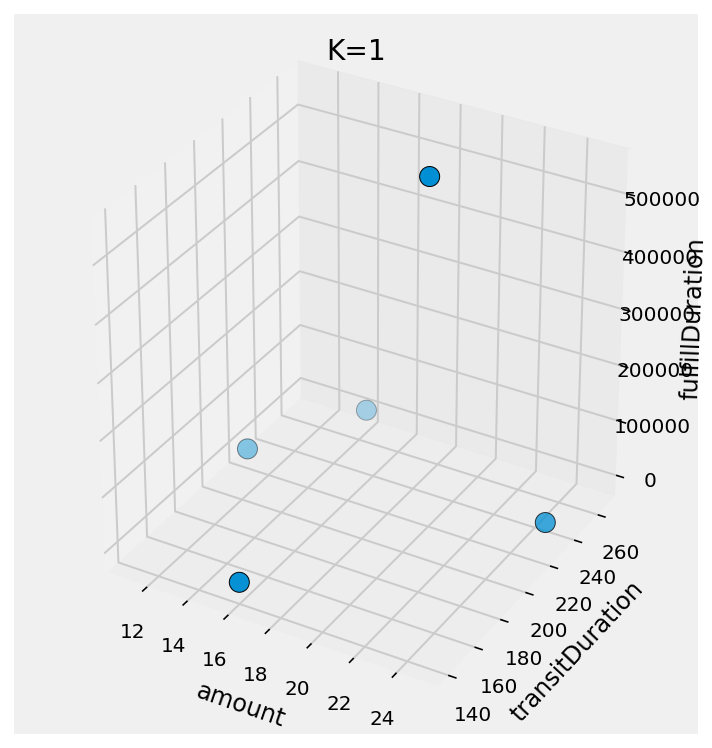

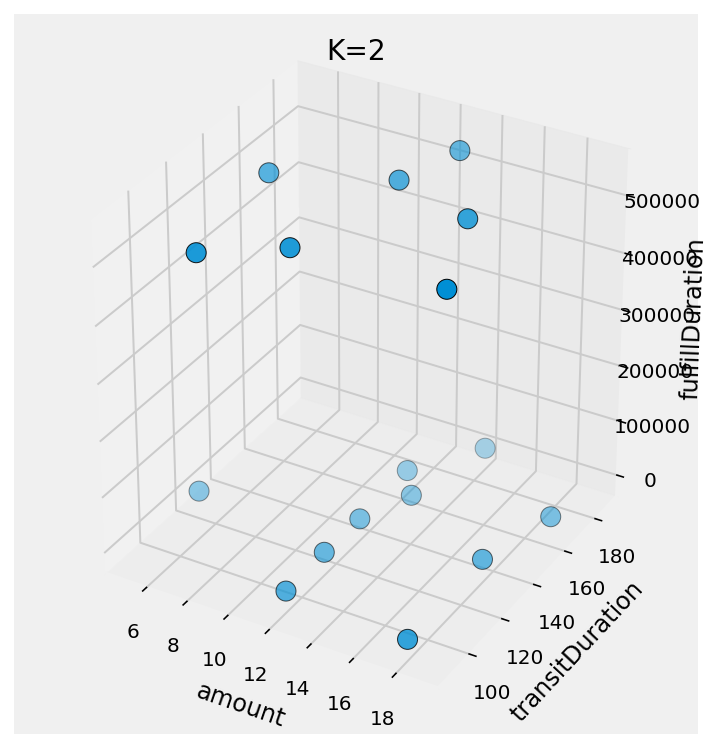

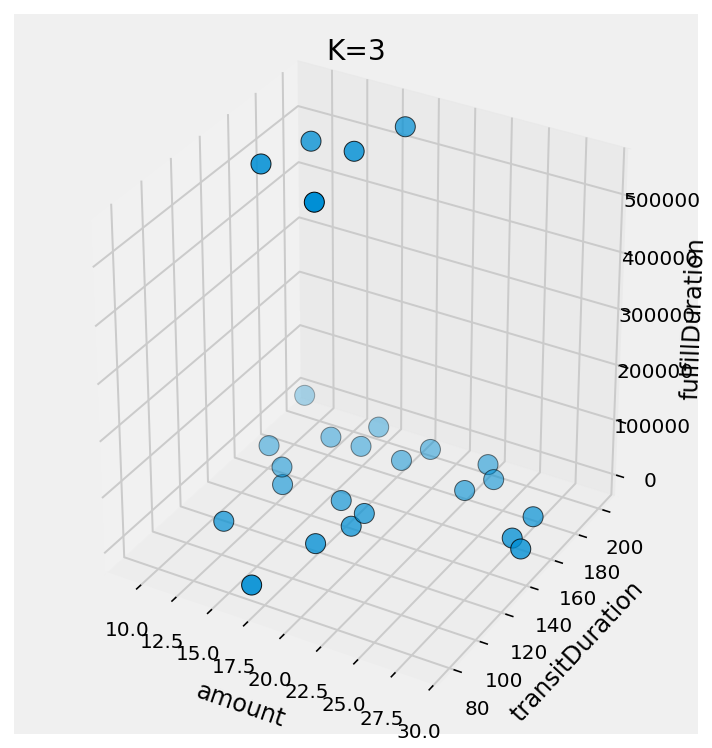

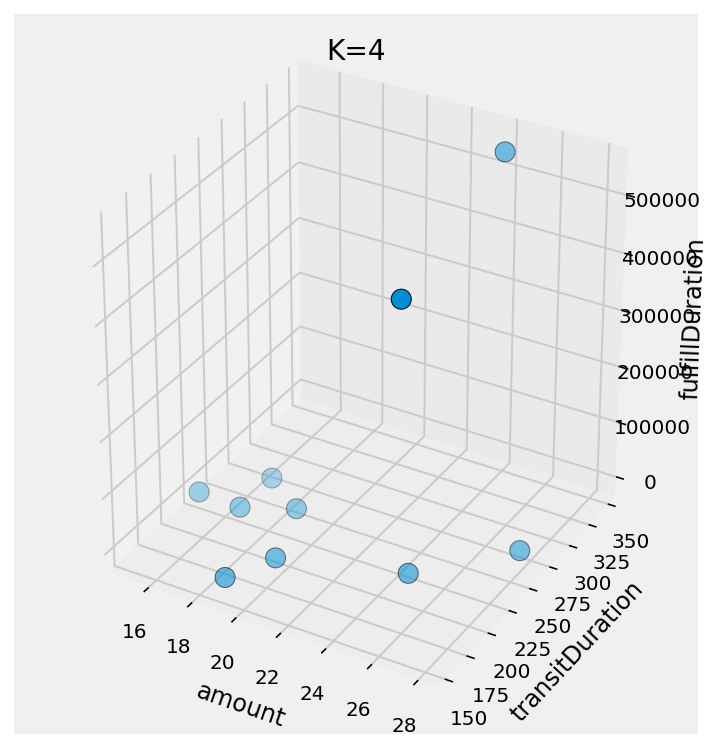

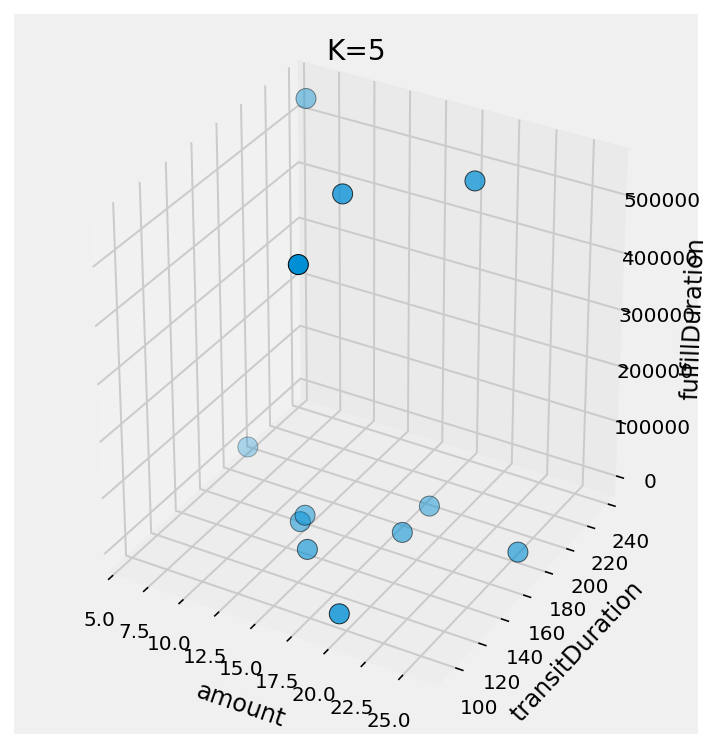

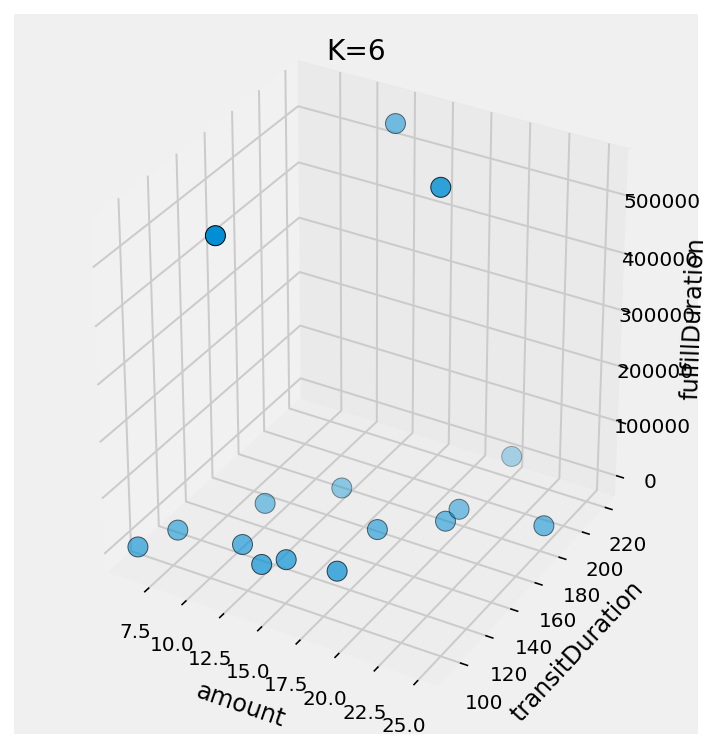

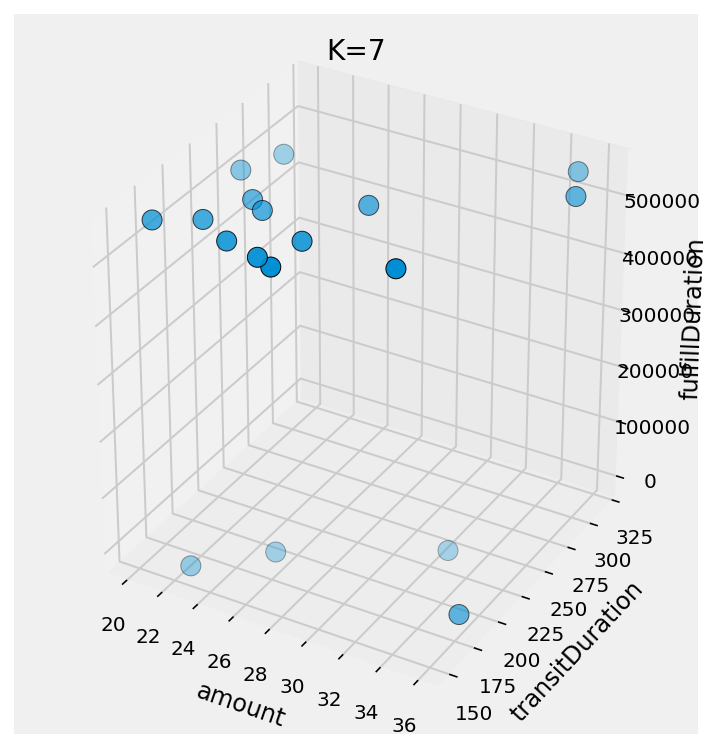

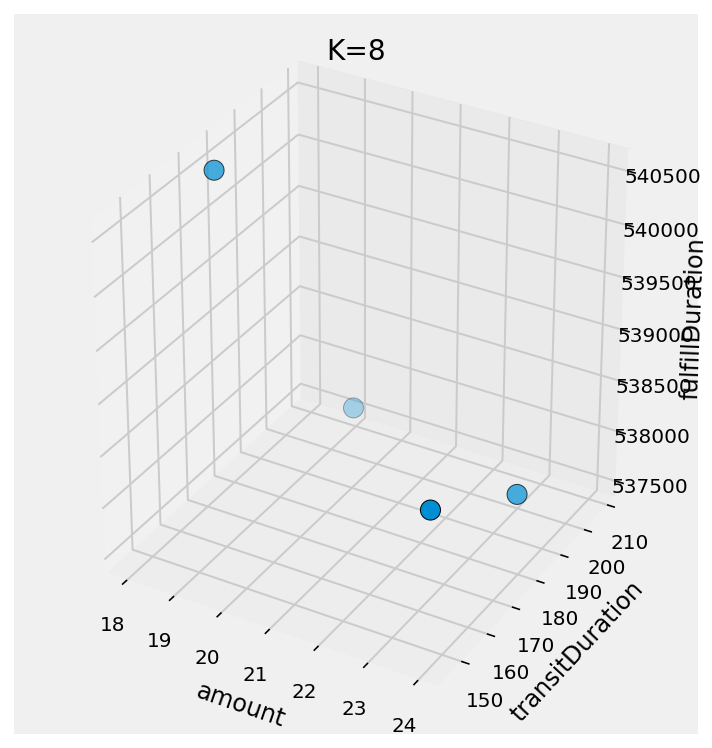

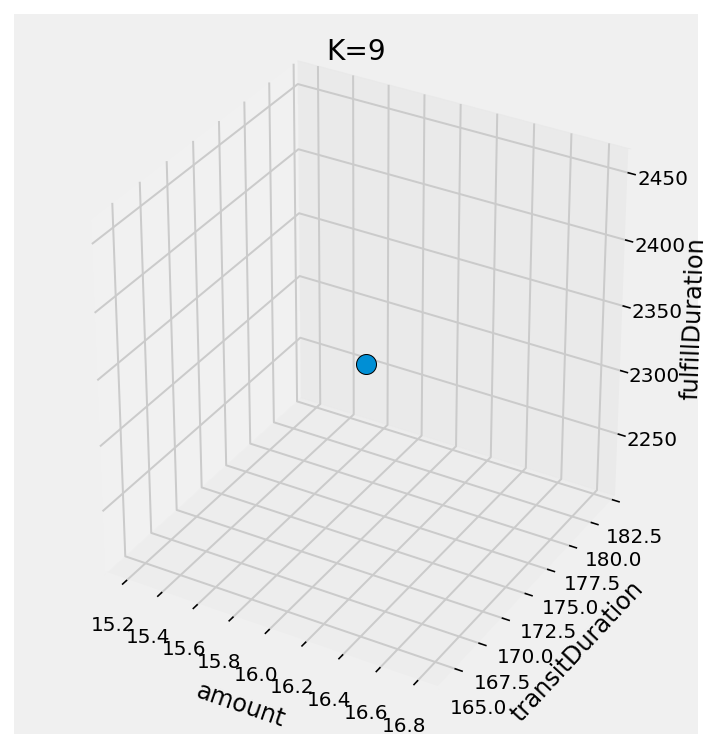

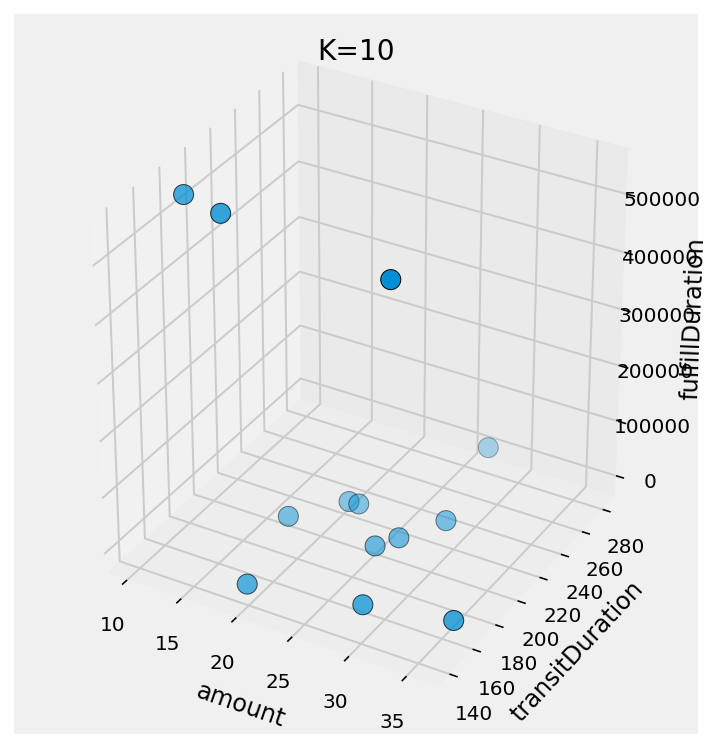

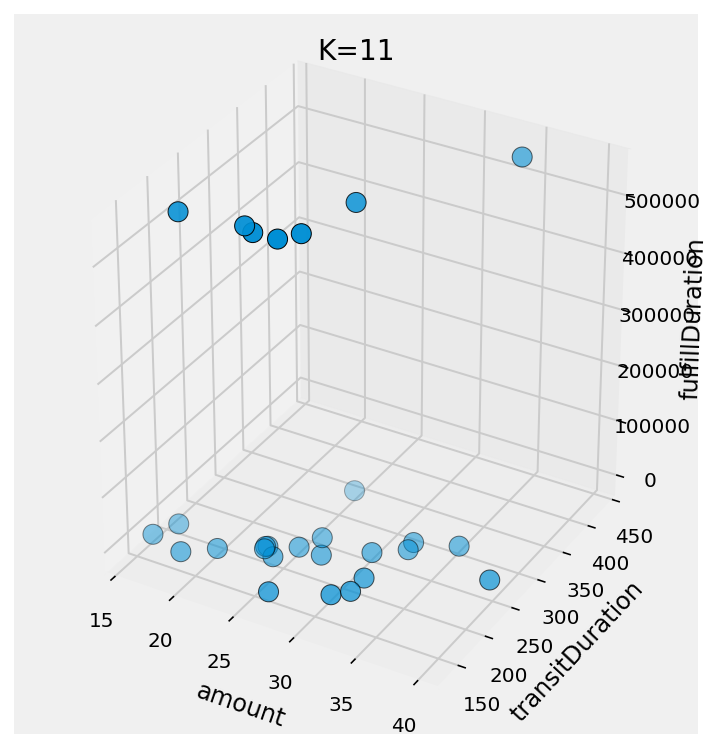

In [5]:
# #Plotting
from mpl_toolkits.mplot3d import Axes3D

for i in xrange(k):
    fig = plt.figure(1, figsize=(5,5))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1])
    ax.scatter(df.loc[cluster[i]]["amount"], df.loc[cluster[i]]["transitDuration"], df.loc[cluster[i]]["fulfillDuration"],edgecolor="k", s=100)
    ax.set_xlabel("amount")
    ax.set_ylabel("transitDuration")
    ax.set_zlabel("fulfillDuration")
    plt.title("K=%d"%(i+1), fontsize=14)
    plt.tight_layout()
    plt.show()